# Data Flow  : Project

Created by :

*   Louis Fontaine
*   Olivier Randavel

This notebook was written following the project of Data Flow course. The data is coming from a Kafka streaming flow. This flow contains clicks and displays of web advertisements by UserId. However, it also includes fraudulent UserID. 

The project aims to create a real-time Flink alert while reading the Kafka streaming flow, that returns fraudulent behaviour. The subject also precise that a CTR of 10% is expected.

This notebook is divided in two parts. The first point decribes our method to find the fake patterns. The data used , is coming from the original Kafka flow and has been recorded in a json file. The second point will focus on obtained results.



#Libraries

As the json file is stored in our drive, we are connected our drive to this colab.

In [ ]:
from google.colab import drive
import json
from datetime import datetime
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Dauphine/Semestre\ 2/Flux\ de\ données/projet
import ast

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Dauphine/Semestre 2/Flux de données/projet


We are using below libraries to explore the data (the profile report describes a dataframe throught an html dashboard)

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport
! pip install cufflinks 
!pip install chart_studio

     \ 38.5MB 1.4MB/s
     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 604kB 17.4MB/s 
     |████████████████████████████████| 3.1MB 26.0MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 296kB 42.3MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.8.0-py2.py3-none-any.whl size=259932 sha256=3bfc750a427b592aac3c86f5af1cc37f7cf2f2625d05511395d2f4ace5669c27
  Stored in directory: /tmp/pip-ephem-wheel-cache-_hrjzrjo/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=1396827b5984e6e377c3551dad9581061ac663cec139a493ef02507774744832
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=2919

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 71kB 2.1MB/s 


#I/ Exploring the data

In [ ]:
def reshape_list_dict_to_dict(d) :
  d_reshape = {"eventType":[""], "uid":[""], "timestamp":[""], "ip":[""], "impressionId": [""]}
  x = "first"
  for dictionnaire in d :
    for key in  [*dictionnaire] : 
      if x != "first" :
        l = d_reshape[key]  
      else : 
        l = []
      d_reshape[key] = l + [dictionnaire[key]]
    x= "other"
  return d_reshape
  
with open('output_2.txt') as f:
    data = ast.literal_eval(f.read())
data = reshape_list_dict_to_dict(data)
df = pd.DataFrame(data,columns=[*data])

In [ ]:
print("The data is going from", datetime.fromtimestamp(min(df.timestamp)) , "to", datetime.fromtimestamp(max(df.timestamp)))

The data is going from 2020-04-30 17:37:53 to 2020-04-30 18:42:33


In [ ]:
df.profile_report()

## Identify patterns

We want to find statistics by uid and ip :
*   We divide our dataset by window sessions of different lenght 15/60 min
*   We compute the Mean of CTR per uid and the global CTR over 15 minutes
*   We are detecting aberant behaviours such as a large number of clicks or displays, or some fake uid that have click without any displays. 



### Mean of CTR

In [ ]:
df1 = df[df["eventType"]=="display"].groupby(["uid","eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display"}).reset_index()
df2 = df[df["eventType"]=="click"].groupby(["uid","eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click"}).reset_index()
total = df1.merge(df2, on='uid', how='inner')
sum_ = []
for i in range(len(total)):
  if total.iloc[i,4] > 0  and total.iloc[i,2] > 0:
    sum_.append(total.iloc[i,4]/total.iloc[i,2])
  if total.iloc[i,4] == "nan"  and total.iloc[i,2] > 0:
    sum_.append(1)
ctr = sum(sum_)/len(sum_)
print("Mean of CTRs is", round(ctr*100,2), "%")

Mean of CTRs is 97.98 %


This metric will not be used as the mean of CTR seems to be too influenced by users having a CTR of 100% (1 click, 1 display)

### Global CTR 

In [ ]:
CTR = df.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
print("Global CTR is", round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2), "%")

Global CTR is 30.23 %


The idea is to start wth a CTR of 30% and to remove fake uids and ips to get a CTR around 10%

### Reduce the Global CTR

#### Remove uid that click with no displays

In [ ]:
def click_wo_display(df) : 
  print("############## Removing uids who click with no display ##############\n")
  display = df[df["eventType"]=="display"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "display"}).reset_index()
  click = df[df["eventType"]=="click"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "click"}).reset_index()
  total = display.merge(click, on='uid', how='outer')
  click_no_impression = total[(total["click"] > 0) & (total["display"] == 0)]
  click_no_impression = click_no_impression.uid.to_list()

  #blacklist impression_id where nbr_click > 0 and display = 0
  df_clean = df[~df["uid"].isin(click_no_impression) ]
  CTR = df_clean.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
  print(len(list(set(click_no_impression))), "impression_id have been removed : ", set(click_no_impression) )

  print("Global CTR is", round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2), "%")
  return df_clean

df1 = click_wo_display(df) 

############## Removing uids who click with no display ##############

0 impression_id have been removed :  set()
Global CTR is 30.23 %


#### Remove ip that interact a lot 

############## Identify fake ip  ##############


The mean of click for all ips is 2.0418761599460096

This boxplot show one outliers


The ip with 3270 interractions is 238.186.83.58


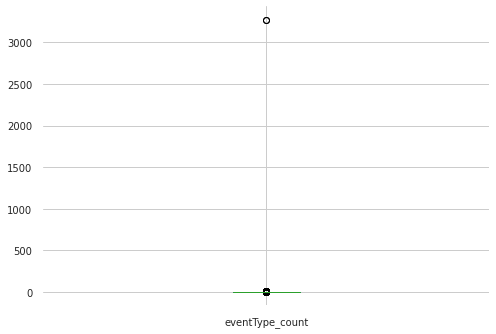

In [ ]:
print("############## Identify fake ip  ##############\n")

df2 = df.groupby(["ip", "eventType"]).agg({'eventType' : 'count', 'impressionId': lambda x: x.nunique(), 'uid': lambda x: x.nunique() }).rename(columns={'eventType': "eventType_count", 'impressionId':'impressionId_unique','uid':'uid_unique'}).reset_index()
max_ = df2.eventType_count.max()

mean_ =  df2.eventType_count.mean()
print("\nThe mean of click for all ips is " + str(mean_) )

print('\nThis boxplot show one outliers\n')
df2.boxplot(column=['eventType_count'] )

ip_name = df2[df2.eventType_count == max_].ip.iloc[1][:]
print("\nThe ip with " + str(max_) + " interractions is " + ip_name)

After removing this ip we get this boxplot : 



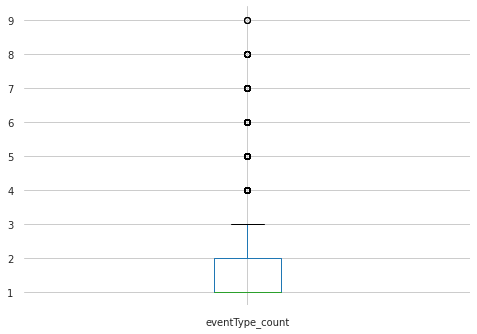

In [ ]:
print('After removing this ip we get this boxplot : \n')
df2[df2.ip != ip_name].boxplot(column=['eventType_count'] )

In [ ]:
def remove_ip_too_much_hits(df, limit) : 
  print("############## Removing ips who have more than " + str(limit) +" hits in 15 minutes ##############\n")

  #create a range of 15 mins
  def stats(df, time_added, limit) :
    df_final = pd.DataFrame()
    start_time = min(df.timestamp)
    end_time = start_time + time_added
    while end_time < max(df.timestamp) : 
      df_temp = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
      df1 = df_temp.groupby(["ip", "eventType"]).agg({'eventType' : 'count', 'impressionId': lambda x: x.nunique(), 'uid': lambda x: x.nunique() }).rename(columns={'eventType': "eventType_count", 'impressionId':'impressionId_unique','uid':'uid_unique'}).reset_index()
      df_final = df_final.append(df1[df1.eventType_count > limit])
      start_time = end_time
      end_time += time_added
    df_temp = df[(df['timestamp'] >= start_time)]
    df1 = df_temp.groupby(["ip", "eventType"]).agg({'eventType' : 'count', 'impressionId': lambda x: x.nunique(), 'uid': lambda x: x.nunique() }).rename(columns={'eventType': "eventType_count", 'impressionId':'impressionId_unique','uid':'uid_unique'}).reset_index()
    df_final = df_final.append(df1[df1.eventType_count > limit])
    return df_final

  df2 = stats(df, 60*15, limit)
  ip = df2.ip.to_list()
  df_clean1 = df[~df["ip"].isin(ip) ]
  df_clean = df_clean1.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
  print(len(list(set(ip))), "ips have been removed :", set(ip))
  print("Global CTR is", round((df_clean.iloc[0]['eventType_count']/df_clean.iloc[1]['eventType_count'])*100,2), "%")
  return df_clean1

df3 = remove_ip_too_much_hits(df, 10)

############## Removing ips who have more than 10 hits in 15 minutes ##############

1 ips have been removed : {'238.186.83.58'}
Global CTR is 24.95 %


#### Remove uids that interact a lot 

##### Over the global data

############## Plot stats over all uids ##############

The blue line shows the cummulative sum of uids over clicks
The red line shows the CTR of the population over clicks


To illustrate, let's consider the nb_clicks = 40, they are 248 000 uids who click from 0 to 40 times and they have a CTR of 22%


From the plot we can see that above 61 clicks, there are around 100 users that increases a lot the CTR.
Therefore we are removing them

The CTR where nbr_click is 60 is equal to 21.54  %



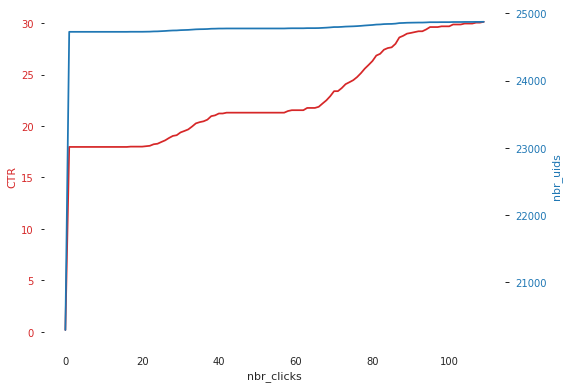


97 uids have been removed : ['84de620c-9fc1-44ca-967b-2ad1efaab532', '76e69c39-c16e-47b0-a959-8e336c83543f', '249cbe10-484e-4c0a-ab47-e2892ae47b18', '74f51a1d-13a7-46f5-803d-5ebd989195a3', 'da40d5b1-a13d-4176-8b62-e015cd69fb55', '0199bc1c-299d-4f26-8892-e3dbe6432951', '432c8dbc-ab7f-4518-a1ba-e8f860d61d61', 'b34e47be-a925-46f7-95b5-c082aa51bd1b', '4008becc-205f-46b9-a993-ca6b3b51e439', '5ce00b4f-a678-4d66-87fe-9f3e5a2084fe', 'b9e5908f-a773-4377-b97c-3394e5e31dda', 'df925a11-0617-4937-95d6-50077626b1bc', '10b2d323-a50b-443b-8bf6-182cd9b16d19', '04a65fb5-6fbd-4b70-a942-03cda26bd494', '0c3ab125-bb36-46af-91f5-ede5e5a3f9d5', 'bb33a098-15a5-4d00-8963-0c6506a7b417', 'b3d4da4b-bad7-44c6-bf3a-370f867a9f94', 'b92fc032-c6b5-4ec6-8e0c-973284563c89', 'e7397369-a0bc-4834-a31f-b3fcfffc27a1', '464bff84-8068-48a7-b1de-a423afa6dfce', '49463231-0d48-4224-96cf-58cb224fa377', '8518f246-142b-4e42-ae3b-217dd6c5bdae', 'f1d42d16-603b-4a89-9be3-6ff5ea686ea5', '4c0f15c9-cc83-435e-8dfa-090a88e87e6a', '64c7067a-

In [ ]:
def show_limit_of_click(df_clean, limit) :
 
  print("############## Plot stats over all uids ##############\n")
  print("The blue line shows the cummulative sum of uids over clicks")
  print("The red line shows the CTR of the population over clicks\n")

  print("\nTo illustrate, let's consider the nb_clicks = 40, they are 248 000 uids who click from 0 to 40 times and they have a CTR of 22%\n")

  print("\nFrom the plot we can see that above 61 clicks, there are around 100 users that increases a lot the CTR.\nTherefore we are removing them\n")



  store = []
  people = []
  x = True
  display_click_par_uid = pd.merge(df_clean[df_clean["eventType"]=="click"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_click"}).reset_index(),
                                   df_clean[df_clean["eventType"]=="display"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_displays"}).reset_index(),on="uid")
  display_click_par_uid["CTR"] = display_click_par_uid["nbr_click"]/display_click_par_uid["nbr_displays"]
  max_ = display_click_par_uid.nbr_click.max()
  for i in range(0,int(max_)):
    display_click_par_uid = pd.merge(df_clean[df_clean["eventType"]=="click"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_click"}).reset_index(),
                                   df_clean[df_clean["eventType"]=="display"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_displays"}).reset_index(),on="uid")
    display_click_par_uid["CTR"] = display_click_par_uid["nbr_click"]/display_click_par_uid["nbr_displays"]
    to_remove = display_click_par_uid[display_click_par_uid["nbr_click"] > i].reset_index().uid.to_numpy()

    df_clean2 = df_clean[~df_clean.uid.isin(to_remove)]
    people.append(df_clean2.uid.nunique()) 
    CTR = df_clean2.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
    ctr = round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2)

    if x == True and i > limit:
        print("The CTR where nbr_click is " + str(limit)+ " is equal to", ctr, " %\n")
        x = i
        removes = to_remove
    store.append(ctr)
  ranges = [i for i in range(0,int(max_))]
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('nbr_clicks')
  ax1.set_ylabel('CTR', color=color)
  ax1.plot(ranges, store, color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('nbr_uids', color=color)  # we already handled the x-label with ax1
  ax2.plot(ranges, people, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  removes = list(set(removes))
  df_clean = df_clean[~df_clean["uid"].isin(removes)]
  df_clean1 = df_clean.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
  print("\n"+ str(len(removes)) + " uids have been removed :", removes)
  print("Global CTR is", round((df_clean1.iloc[0]['eventType_count']/df_clean1.iloc[1]['eventType_count'])*100,2), "%")
  return df_clean
df3 = show_limit_of_click(df, 60)

##### Over fifteen minutes of data

############## Removing uids, in a range of 15.0 minutes, with more than 40 clicks ##############


The CTR where nbr_click is 40 is equal to 18.23  %




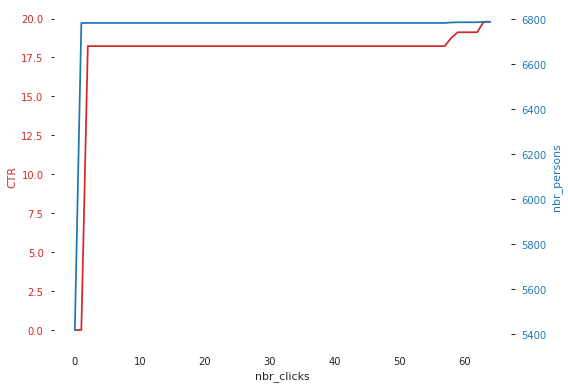

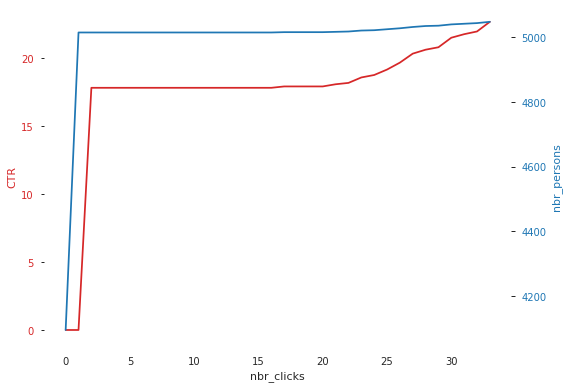

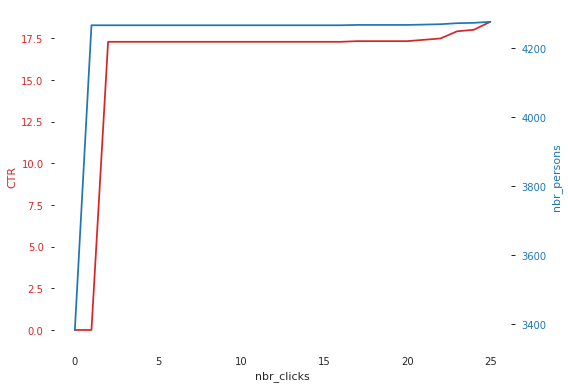


The CTR where nbr_click is 40 is equal to 18.46  %




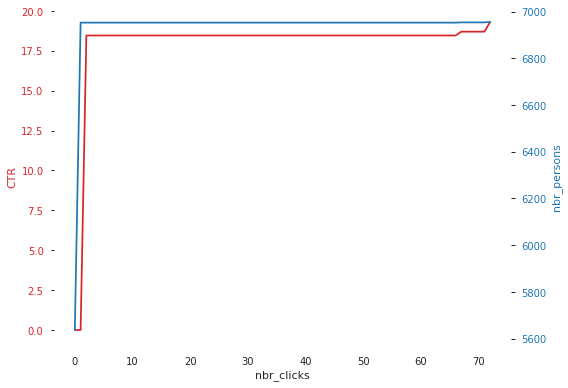

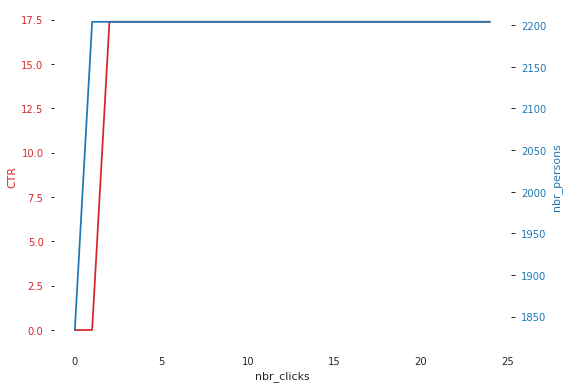


101 uids have been removed : ['84de620c-9fc1-44ca-967b-2ad1efaab532', '76e69c39-c16e-47b0-a959-8e336c83543f', '249cbe10-484e-4c0a-ab47-e2892ae47b18', '74f51a1d-13a7-46f5-803d-5ebd989195a3', 'f67adf8e-c859-41db-a0a6-b3932efc3d2d', 'da40d5b1-a13d-4176-8b62-e015cd69fb55', '0199bc1c-299d-4f26-8892-e3dbe6432951', '432c8dbc-ab7f-4518-a1ba-e8f860d61d61', 'b34e47be-a925-46f7-95b5-c082aa51bd1b', '4008becc-205f-46b9-a993-ca6b3b51e439', '5ce00b4f-a678-4d66-87fe-9f3e5a2084fe', 'b9e5908f-a773-4377-b97c-3394e5e31dda', 'df925a11-0617-4937-95d6-50077626b1bc', '10b2d323-a50b-443b-8bf6-182cd9b16d19', '04a65fb5-6fbd-4b70-a942-03cda26bd494', '0c3ab125-bb36-46af-91f5-ede5e5a3f9d5', 'bb33a098-15a5-4d00-8963-0c6506a7b417', 'b3d4da4b-bad7-44c6-bf3a-370f867a9f94', 'b92fc032-c6b5-4ec6-8e0c-973284563c89', 'e7397369-a0bc-4834-a31f-b3fcfffc27a1', '464bff84-8068-48a7-b1de-a423afa6dfce', '49463231-0d48-4224-96cf-58cb224fa377', '8518f246-142b-4e42-ae3b-217dd6c5bdae', 'f1d42d16-603b-4a89-9be3-6ff5ea686ea5', 'b5f24428

In [ ]:
def show_limit_of_click2(df_clean, time_added, limit, show = True) :
  print("############## Removing uids, in a range of "+ str(time_added/60) + " minutes, with more than "+ str(limit) + " clicks ##############\n")

  def t(l,df_clean,start_time,end_time):
    store = []
    people = []
    x = True
    display_click_par_uid = pd.merge(df_clean[(df_clean['timestamp'] >= start_time) & (df_clean['timestamp'] < end_time) & (df_clean["eventType"]=="click")]
                                    .groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_click"}).reset_index(),
                                    df_clean[(df_clean['timestamp'] >= start_time) & (df_clean['timestamp'] < end_time) & (df_clean["eventType"]=="display")]
                                    .groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_displays"}).reset_index(),on="uid")
    display_click_par_uid["CTR"] = display_click_par_uid["nbr_click"]/display_click_par_uid["nbr_displays"]
    max_ = display_click_par_uid.nbr_click.max()
    for i in range(0,int(max_)):
      display_click_par_uid = pd.merge(df_clean[df_clean["eventType"]=="click"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_click"}).reset_index(),
                                    df_clean[df_clean["eventType"]=="display"].groupby(["uid"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "nbr_displays"}).reset_index(),on="uid")
      display_click_par_uid["CTR"] = display_click_par_uid["nbr_click"]/display_click_par_uid["nbr_displays"]
      to_remove = display_click_par_uid[display_click_par_uid["nbr_click"] > i].reset_index().uid.to_numpy()
      
      df_clean2 =  df_clean[(df_clean['timestamp'] >= start_time) & (df_clean['timestamp'] < end_time)]
      df_clean2 = df_clean2[~df_clean2.uid.isin(to_remove)]
      people.append(df_clean2.uid.nunique()) 
      CTR = df_clean2.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
      if i > 1 : 
        ctr = round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2)
      else : 
        ctr = 0     
      if x == True and i  > limit:
        if show :
          print("\nThe CTR where nbr_click is " + str(limit)+ " is equal to", ctr, " %\n")
        x = i
        l.append(i)
        remove = to_remove
      store.append(ctr)
    if show : 
      print()

      ranges = [i for i in range(0,int(max_))]
      fig, ax1 = plt.subplots()
      
      color = 'tab:red'
      ax1.set_xlabel('nbr_clicks')
      ax1.set_ylabel('CTR', color=color)
      ax1.plot(ranges, store, color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

      color = 'tab:blue'
      ax2.set_ylabel('nbr_persons', color=color)  # we already handled the x-label with ax1
      ax2.plot(ranges, people, color=color)
      ax2.tick_params(axis='y', labelcolor=color)

      fig.tight_layout()  # otherwise the right y-label is slightly clipped
      plt.show()
    if x == True :
      remove = []
    return l, remove
  
  l = []
  removes = []
  start_time = min(df_clean.timestamp)
  end_time = start_time + time_added
  while end_time < max(df_clean.timestamp) : 
    l, remove = t(l, df_clean, start_time, end_time)
    removes = np.append(removes, remove)
    start_time = end_time
    end_time += time_added
  l, remove = t(l, df_clean, start_time, max(df_clean.timestamp))
  removes = np.append(removes, remove)
  removes = list(set(removes))
  df_clean = df_clean[~df_clean["uid"].isin(removes)]
  df_clean1 = df_clean.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
  print("\n"+ str(len(removes)) + " uids have been removed :", removes)
  print("Global CTR is", round((df_clean1.iloc[0]['eventType_count']/df_clean1.iloc[1]['eventType_count'])*100,2), "%")
  return df_clean
df4 = show_limit_of_click2(df, 60*15, 40, show = True)

We can see that both methods result in a similar CTR therfore we will implement the second method by setting a maximum number of clicks of 40 over 15 minutes.

##Overall

In [ ]:
print("###### Start ######\n")

print("The data goes from ", datetime.fromtimestamp(min(df.timestamp)) , "to ", datetime.fromtimestamp(max(df.timestamp)))
CTR = df.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
print("CTR is", round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2), "%", "\n")

df5 = click_wo_display(df)
print()

df5 = remove_ip_too_much_hits(df5,10)
print()
df5 = show_limit_of_click2(df5, 60*15, 40, show = False)

print("\n###### END ######")

###### Start ######

The data goes from  2020-04-30 17:37:53 to  2020-04-30 18:42:33
CTR is 30.23 % 

############## Removing uids who click with no display ##############

0 impression_id have been removed :  set()
Global CTR is 30.23 %

############## Removing ips who have more than 10 hits in 15 minutes ##############

1 ips have been removed : {'238.186.83.58'}
Global CTR is 24.95 %

############## Removing uids, in a range of 15.0 minutes, with more than 40 clicks ##############


101 uids have been removed : ['84de620c-9fc1-44ca-967b-2ad1efaab532', '76e69c39-c16e-47b0-a959-8e336c83543f', '249cbe10-484e-4c0a-ab47-e2892ae47b18', '74f51a1d-13a7-46f5-803d-5ebd989195a3', 'f67adf8e-c859-41db-a0a6-b3932efc3d2d', 'da40d5b1-a13d-4176-8b62-e015cd69fb55', '0199bc1c-299d-4f26-8892-e3dbe6432951', '432c8dbc-ab7f-4518-a1ba-e8f860d61d61', 'b34e47be-a925-46f7-95b5-c082aa51bd1b', '4008becc-205f-46b9-a993-ca6b3b51e439', '5ce00b4f-a678-4d66-87fe-9f3e5a2084fe', 'b9e5908f-a773-4377-b97c-3394e5e31dda',

#II/ Evaluate the results

Our data is stored on our drive and is splitted in three files. These files has been generated with the alert job implemented using Flink :

*   Event.txt : contains the list of events ("eventType", "uid", "timestamp", "ip", "impressionId")
*   uid_alert.txt : contains all uids that make more than 40 clicks within 15 minutes
*   ip_alert.txt : contains all ips with more than 10 hits within 15 minutes



In [ ]:
%cd /content/drive/My\ Drive/Dauphine/Semestre\ 2/Flux\ de\ données/projet

/content/drive/My Drive/Dauphine/Semestre 2/Flux de données/projet


##Flink Method 

In [ ]:
import ast
with open('events.txt') as f:
    data = f.read().splitlines()
d_reshape = {"eventType":[""], "uid":[""], "timestamp":[""], "ip":[""], "impressionId": [""]}
timestamp = []
for i in data :  
  temp = ast.literal_eval(i.replace("=", ":").replace("impressionId", "'impressionId'"))
  d_reshape["eventType"] += [temp["eventType"]]
  d_reshape["uid"] += [temp["uid"]]
  d_reshape["timestamp"] += [temp["timestamp"]]
  timestamp.append(temp["timestamp"])
  d_reshape["ip"] += [temp["ip"]]
  d_reshape["impressionId"] += [temp["impressionId"]]
df = pd.DataFrame(d_reshape,columns=[*d_reshape])
min_, max_ = min(timestamp), max(timestamp)
with open('uid_alert.txt') as f:
    uid_to_remove = f.read().splitlines()

In [ ]:
df1 = df[~df["uid"].isin(uid_to_remove)]
df1 = df1[~df1["ip"].isin(["238.186.83.58"])]
print("This sample starts", datetime.fromtimestamp(min_), "and ends ", datetime.fromtimestamp(max_) , "." )
print("The number of uids removed is", len(uid_to_remove), "and 1 ip." )

This sample starts 2020-06-22 17:49:40 and ends  2020-06-22 18:08:41 .
The number of uids removed is 50 and 1 ip.


In [ ]:
CTR = df.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
print("Global CTR is", round((CTR.iloc[1]['eventType_count']/CTR.iloc[2]['eventType_count'])*100,2), "%")
CTR

Global CTR is 33.18 %


,eventType,eventType_count
0,,1
1,click,5364
2,display,16164


In [ ]:
CTR = df1.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
print("Global CTR is", round((CTR.iloc[1]['eventType_count']/CTR.iloc[2]['eventType_count'])*100,2), "%")
CTR

Global CTR is 13.11 %


,eventType,eventType_count
0,,1
1,click,985
2,display,7512


##The method define in part I/

In [ ]:
print("###### Start ######\n")
df = df[(df.timestamp!= "")]

df.astype({'timestamp': 'int32'}).dtypes

print("La donnée s'étend du", datetime.fromtimestamp(min(df.timestamp)) , "au", datetime.fromtimestamp(max(df.timestamp)))
CTR = df.groupby(["eventType"]).agg({'eventType' : 'count'}).rename(columns={'eventType': "eventType_count"}).reset_index()
print("CTR is", round((CTR.iloc[0]['eventType_count']/CTR.iloc[1]['eventType_count'])*100,2), "%", "\n")

df5 = click_wo_display(df)
print()

df5 = remove_ip_too_much_hits(df5,10)
print()
df5 = show_limit_of_click2(df5, 60*15, 40, show = False)

print("\n###### END ######")

###### Start ######

La donnée s'étend du 2020-06-22 17:49:40 au 2020-06-22 18:08:41
CTR is 33.18 % 

############## Removing uids who click with no display ##############

0 impression_id have been removed :  set()
Global CTR is 33.18 %

############## Removing ips who have more than 10 hits in 15 minutes ##############

1 ips have been removed : {'238.186.83.58'}
Global CTR is 28.12 %

############## Removing uids, in a range of 15.0 minutes, with more than 40 clicks ##############


50 uids have been removed : ['af2bef2c-6059-4ab3-8207-c8a530652a9b', 'ec10cbc1-4ee4-4336-b5a5-d358a920e841', '4690fb13-9942-43c3-b933-bb4d1afbe4c3', '9006939d-0dc1-424f-8f2b-332bb4ffafe8', '9127f971-e1bc-4b9d-aae2-d7d458e070da', 'f50c3d1f-0e3d-43a7-bef2-7d8d22d35929', '06fab9c3-c83a-4cf7-8b57-fbbca016981b', '98c628f0-ad73-4b4c-97a0-8bcb64eabdb8', 'b9d9e00b-4fb7-44ce-a1bc-687aa0ef0621', '3edba026-f8f3-4e18-899e-0aa8bf9290b2', '7f062d88-7948-43a9-8924-2b4ffe162f18', 'c6c90161-cc6b-4646-bdf7-2f05bfd156e8', 

#Conclusion

Our aim was to identify uids and ips that have an aberant behaviour. A normal CTR should be around 10%.

As a result we identify 50 uids and 1 ip. The global CTR decreases from 33% to 13%. 

Besides, the implementation using Flink coincides exacly with the pre-study. Indeed, the same uids and ip are removed and the CTR obtained is the same. We can conclude that the implementation is good and can be pushed in production state. 